In [1]:
from __future__ import print_function
%matplotlib inline  

import numpy as np
import keras
import cPickle
import matplotlib.pyplot as plt


Using Theano backend.
Using gpu device 0: GeForce GTX 780 (CNMeM is disabled, cuDNN 4007)


In [2]:
def collage(data):
    images = [img for img in data.transpose(0, 2, 3, 1)]
    side = int(np.ceil(len(images)**0.5))
    for i in range(side**2 - len(images)):
        images.append(images[-1])
    collage = [np.concatenate(images[i::side], axis=0)
               for i in range(side)]
    collage = np.concatenate(collage, axis=1)
    #collage -= collage.min()
    #collage = collage / np.absolute(collage).max() * 256
    return collage
    

## Read data from CIFAR 10

Trn data shape: (80000, 3, 32, 32)
Tst data shape: (20000, 3, 32, 32)


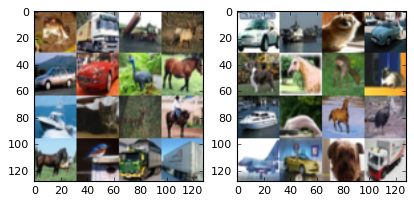

Trn labels shape:  (80000, 10)
Tst labels shape:  (20000, 10)
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]


In [3]:
trnData = []
trnLabels = []
tstData = []
tstLabels = []
for i in range(1,6):
    with open('data_batch_{}'.format(i)) as f:
        data = cPickle.load(f)
    if i == 5:
        tstData = data['data']
        tstLabels = data['labels']
    else:
        trnData.append(data['data'])
        trnLabels.append(data['labels'])
trnData = np.concatenate(trnData).reshape(-1, 3, 32, 32)
trnData = np.concatenate([trnData[:,:,:,::-1], trnData[:,:,:,:]])
trnLabels = np.concatenate(trnLabels)
trnLabels = np.concatenate([trnLabels, trnLabels])
tstData = tstData.reshape(-1, 3, 32, 32)
tstData = np.concatenate([tstData[:,:,:,::-1], tstData[:,:,:,:]])
tstLabels = np.concatenate([tstLabels, tstLabels])

print('Trn data shape:', trnData.shape)
print('Tst data shape:', tstData.shape)
plt.subplot(1, 2, 1)
img = collage(trnData[:16])
plt.imshow(img)
plt.subplot(1, 2, 2)
img = collage(tstData[:16])
plt.imshow(img)
plt.show()

def mapLabels(data):
    data = np.asarray(data)
    class_no = int(data.max()+1)
    out = np.zeros((data.shape[0], class_no)).astype(np.float32)
    out[range(out.shape[0]), data.astype(int)] = 1
    return out
trnLabels = mapLabels(trnLabels)
tstLabels = mapLabels(tstLabels)
print('Trn labels shape: ', trnLabels.shape)
print('Tst labels shape: ', tstLabels.shape)
print(trnLabels[:5,:])
print(tstLabels[:5,:])

## Normalize data

In [4]:
trnData = trnData.astype(np.float32) / 255 - 0.5
tstData = tstData.astype(np.float32) / 255 - 0.5
'''def zca_whitening(inputs):
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    epsilon = 0.1                #Whitening constant, it prevents division by zero
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)                     #ZCA Whitening matrix
    return ZCAMatrix
np.dot(ZCAMatrix, inputs)
'''


'def zca_whitening(inputs):\n    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix\n    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition\n    epsilon = 0.1                #Whitening constant, it prevents division by zero\n    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)                     #ZCA Whitening matrix\n    return ZCAMatrix\nnp.dot(ZCAMatrix, inputs)\n'

## Create network + compilemodel

In [5]:
def C_BN_RELU(net, k_count, size, name, border='valid'):
    from keras.layers import Convolution2D, BatchNormalization, Activation
   
    net = Convolution2D(k_count, size, size, name=name,
            init='glorot_uniform',
            border_mode=border, 
            dim_ordering='th')(net)
    net = BatchNormalization(epsilon=0.001, mode=0, axis=1, momentum=0.99, 
            weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, 
            beta_regularizer=None)(net)
    net = Activation('relu')(net)
    return net

    
def CNN_L4(in_dim):
    from keras.layers import Input, Convolution2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Flatten
    from keras.layers import BatchNormalization, Activation
    input_data = Input(shape=(in_dim), name='data')

    net = C_BN_RELU(input_data, 32, 5, name='conv1', border='valid')  
    net = C_BN_RELU(net, 64, 3, name='conv2', border='valid')  
    net = Dropout(0.4)(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool2',
            border_mode='same', dim_ordering='th')(net)
    net = C_BN_RELU(net, 128, 3, name='conv3', border='same')  
    net = C_BN_RELU(net, 128, 3, name='conv4', border='same')  
    net = Dropout(0.4)(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool4',
            border_mode='same', dim_ordering='th')(net)
    net = C_BN_RELU(net, 256, 3, name='conv5', border='same')  
    net = C_BN_RELU(net, 256, 3, name='conv6', border='same')  
    net = Dropout(0.4)(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool6',
            border_mode='same', dim_ordering='th')(net)
    net = Flatten()(net)
    net = Dense(256, name='fc7', activation='relu')(net)
    net = Dropout(0.5, name='drop7')(net)
    net = Dense(256, name='fc8', activation='relu')(net)
    net = Dropout(0.5, name='drop8')(net)
    net = Dense(10, name='fc9', activation='softmax')(net)
    from keras.models import Model
    model = Model(input=[input_data], output=[net])

    return model

def CNN_L9(in_dim):
    from keras.layers import Input, Convolution2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Flatten
    from keras.layers import BatchNormalization, Activation
    input_data = Input(shape=(in_dim), name='data')

    net = conv(32, 5, name='conv1', border='valid')(input_data)
    net = conv(32, 3, name='conv2', border='valid')(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool2',
            border_mode='same', dim_ordering='th')(net)
    net = conv(64, 3, name='conv3', border='same')(net)
    net = conv(64, 3, name='conv4', border='same')(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool4',
            border_mode='same', dim_ordering='th')(net)
    net = conv(128, 3, name='conv5', border='same')(net)
    net = conv(128, 3, name='conv6', border='same')(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool6',
            border_mode='same', dim_ordering='th')(net)
    net = Flatten()(net)
    net = Dense(256, name='fc7', activation='relu')(net)
    net = Dropout(0.5, name='drop7')(net)
    net = Dense(256, name='fc8', activation='relu')(net)
    net = Dropout(0.5, name='drop8')(net)
    net = Dense(10, name='fc9', activation='softmax')(net)
    from keras.models import Model
    model = Model(input=[input_data], output=[net])

    return model

In [6]:
def recursiveCNN(in_dim):
    from keras.layers import Input, MaxPooling2D, Dense, Dropout, Flatten
    recLayer32 = conv(32, 3, name='r32')
    recLayer64 = conv(64, 3, name='r64')
    recLayer128 = conv(128, 3, name='r128')
    recLayer256 = conv(256, 3, name='r256',border='valid')
    dense128 = Dense(128, name='fc', activation='relu')
    dense256 = Dense(256, name='fc', activation='relu')

    input_data = Input(shape=(in_dim), name='data')

    net = conv(32, 5, name='conv1', border='valid')(input_data)
    net = conv(64, 3, name='conv2', border='valid')(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool2',
            border_mode='same', dim_ordering='th')(net)    
    
    net = recLayer64(net)
    net = recLayer64(net)
    net = recLayer64(net)
    net = conv(128, 3, name='conv5', border='valid')(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool6',
            border_mode='same', dim_ordering='th')(net)    
    
    net = recLayer128(net)
    net = recLayer128(net)
    net = recLayer128(net)
    
    net = keras.layers.local.LocallyConnected2D(
        128, 3, 3, activation='relu', border_mode='valid')(net)    
    net = Dropout(0.5)(net)
    net = keras.layers.local.LocallyConnected2D(
        128, 3, 3, activation='relu', border_mode='valid')(net)    
    net = Dropout(0.5)(net)
    
    net = Flatten()(net)
    net = Dense(10, name='fc9', activation='softmax')(net)
    from keras.models import Model
    model = Model(input=[input_data], output=[net])

    return model    
    
    

In [7]:
from keras.regularizers import l2

w_decay = 0.0005
w_reg = l2(w_decay)

def conv(count, size, name=None, border='same'):
    from keras.layers import Convolution2D
    layer = Convolution2D(count, size, size, name=name,
        init='he_uniform',
        border_mode=border, 
        activation='relu',
        W_regularizer=w_reg,
        dim_ordering='th')
    return layer

def recursiveCNN_2(in_dim):
    from keras.layers import Input, MaxPooling2D, Dense, Dropout, Flatten
    recLayer32 = conv(32, 3, name='r32')
    recLayer64 = conv(64, 3, name='r64')
    recLayer128 = conv(128, 3, name='r128')
    recLayer256 = conv(256, 3, name='r256',border='valid')
    dense128 = Dense(128, name='fc', activation='relu')
    dense256 = Dense(256, name='fc', activation='relu')

    input_data = Input(shape=(in_dim), name='data')

    net = conv(32, 5, border='valid')(input_data)
    net = conv(32, 3, border='valid')(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool2',
            border_mode='same', dim_ordering='th')(net)    
    
    net = conv(48, 3, border='same')(net)
    net = conv(48, 3, border='same')(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool6',
            border_mode='same', dim_ordering='th')(net)    
    net = conv(64, 3, border='same')(net)
    net = keras.layers.local.LocallyConnected2D(
        32, 3, 3, activation='relu', W_regularizer=w_reg, border_mode='valid')(net)    
    net = Dropout(0.5)(net)
    net = keras.layers.local.LocallyConnected2D(
        32, 3, 3, activation='relu', W_regularizer=w_reg, border_mode='valid')(net)    
    net = Dropout(0.5)(net)
    
    net = Flatten()(net)
    net = Dense(10, name='fc9', W_regularizer=l2(0.000001), activation='softmax')(net)
    from keras.models import Model
    model = Model(input=[input_data], output=[net])

    return model    

In [15]:
# models from STRIVING FOR SIMPLICITY:THE ALL CONVOLUTIONAL NET

def CIFAR_A(in_dim):
    from keras.layers import Input, MaxPooling2D, Dense, Dropout, Flatten, AveragePooling2D, Activation
    input_data = Input(shape=(in_dim), name='data')
    net = Dropout(0.2)(input_data)
    net = conv(96, 5, border='valid')(input_data)
    net = MaxPooling2D((3,3), strides=(2,2), 
            border_mode='same', dim_ordering='th')(net)    
    net = Dropout(0.5)(net)
    net = conv(192, 5, border='same')(net)
    net = MaxPooling2D((3,3), strides=(2,2), 
            border_mode='same', dim_ordering='th')(net)    
    net = Dropout(0.5)(net)
    net = conv(192, 5, border='same')(net)
    net = conv(192, 1, border='same')(net)
    net = conv(10, 1, border='same')(net)
    net = AveragePooling2D ((6,6), strides=(6,6), 
            border_mode='valid', dim_ordering='th')(net)
    net = Flatten()(net)
    net = Activation('softmax')(net)    
    from keras.models import Model
    model = Model(input=[input_data], output=[net])

    return model    

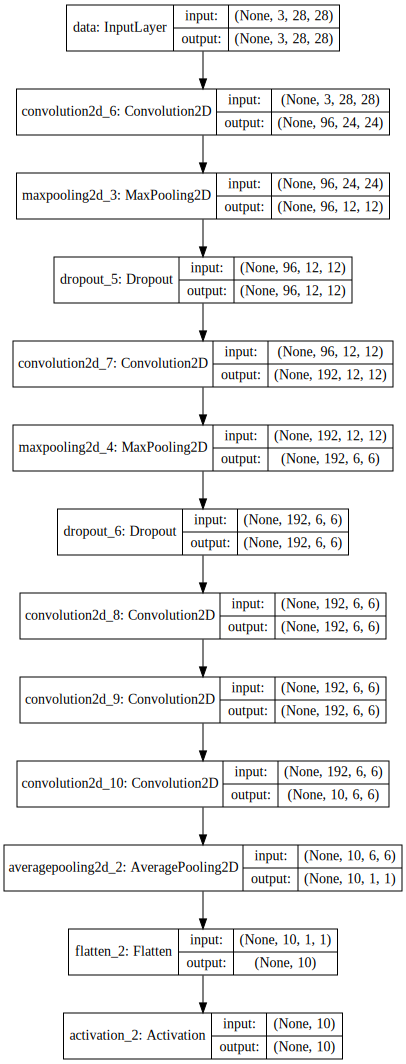

In [16]:
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
dataSize = 28
model = CIFAR_A((3,dataSize,dataSize))

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# show network
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Data Generator 
It randomly crops training images

In [17]:
# data generator
from functools import partial
from numpy.random import randint

def generator(data, labels, targetSize, batchSize):
    nb_samples = data.shape[0]
    border = [data.shape[2]-targetSize, data.shape[3]-targetSize]
    while True:
        perm = np.random.permutation(nb_samples)
        for i in range(0, nb_samples-batchSize, batchSize):
            batchLabels = labels[perm[i:i+batchSize]]
            batchData = data[perm[i:i+batchSize]]
            if border[0]:
                crops = []
                borders = np.stack([randint(b, size=batchSize) for b in border], axis=-1)
                for sample, b in zip(batchData, borders):
                    crops.append(sample[:, b[0]:b[0]+targetSize, b[1]:b[1]+targetSize])
                batchData = np.stack(crops)
            yield  batchData, batchLabels
    print('out')

    


## Prepare generator and show data from the generator

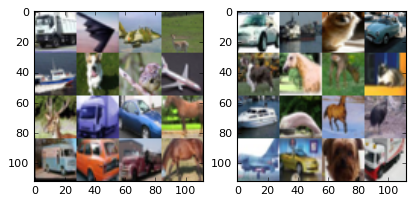

DONE


In [27]:
border = 32 - dataSize
#central crop validation data
valData = tstData[:,:,border:border+dataSize, border:border+dataSize]
plt.subplot(1, 2, 1)
plt.subplot(1, 2, 2)
img = collage(valData[:16] + 0.5)
plt.imshow(img)


gen1 = generator(data=trnData, labels=trnLabels, targetSize=dataSize, batchSize=512)

import itertools
for batchData in itertools.islice(gen1, 1):
    img = collage(batchData[0][:16])
    plt.subplot(1, 2, 1)
    plt.imshow(img + 0.5)
plt.show()
# it(
#    {'data':trnData}, trnLabels,
#    validation_data=(tstData, tstLabels),
#    batch_size=512, nb_epoch=20)
print('DONE')



In [ ]:
model.optimizer.lr = 0.001
while True:
    print('LERANING RATE', model.optimizer.lr)
    model.fit_generator(
        gen1, 
        samples_per_epoch = 40000, 
        nb_epoch = 30,  validation_data=(valData, tstLabels), nb_worker=1)
    model.optimizer.lr *= 0.5

LERANING RATE 0.001
Epoch 1/30
21504/40000 [===============>..............] - ETA: 13s - loss: 0.8781 - acc: 0.7740